In [124]:
import json
import requests as r
from shapely.geometry import mapping, shape

In [126]:
res = r.get('https://s3.amazonaws.com/chicago.bnroths.com/data/boundaries/ZillowNeighborhaoods-IL.json').json()
with open('zillow.json', 'wb') as f:
    f.write(json.dumps(res))
res = r.get('https://s3.amazonaws.com/chicago.bnroths.com/data/boundaries/Boundaries+-+Census+Tracts+-+2010.json').json()
with open('tracts.json', 'wb') as f:
    f.write(json.dumps(res))

In [195]:
tracts = gpd.read_file('tracts.json')
neighborhoods = gpd.read_file('zillow.json')

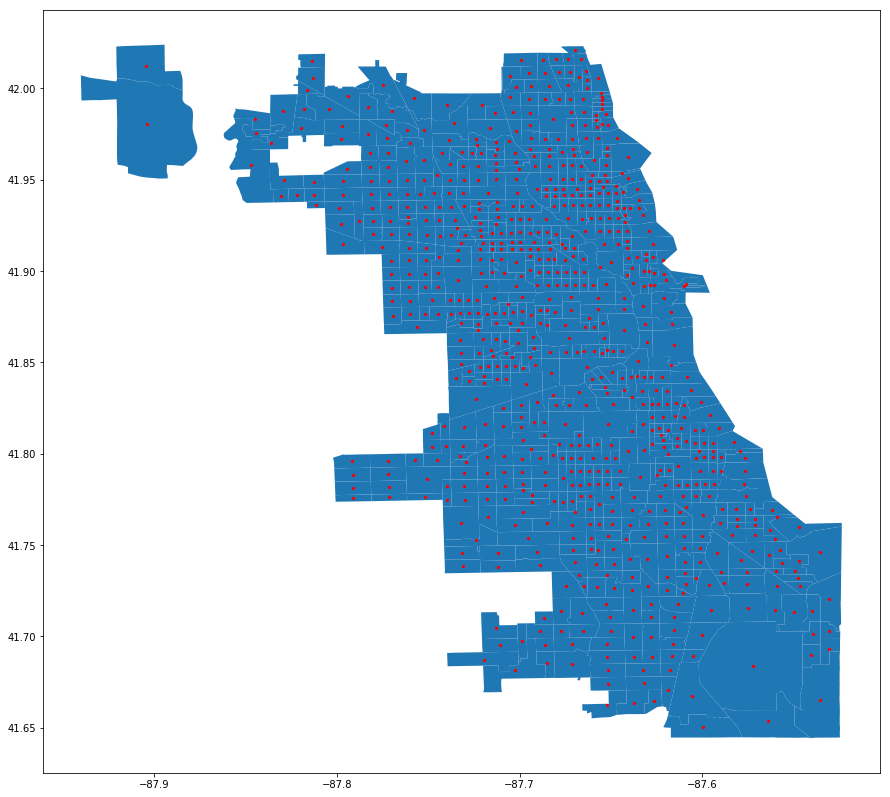

In [214]:
base = tracts.plot(figsize=(15,15))
tracts_center = tracts
tracts_center['centroid_column'] = tracts.centroid
tracts_center = tracts.set_geometry('centroid_column')
tracts_center.plot(ax=base, marker='o', color='red', markersize=5, figsize=(5,5));

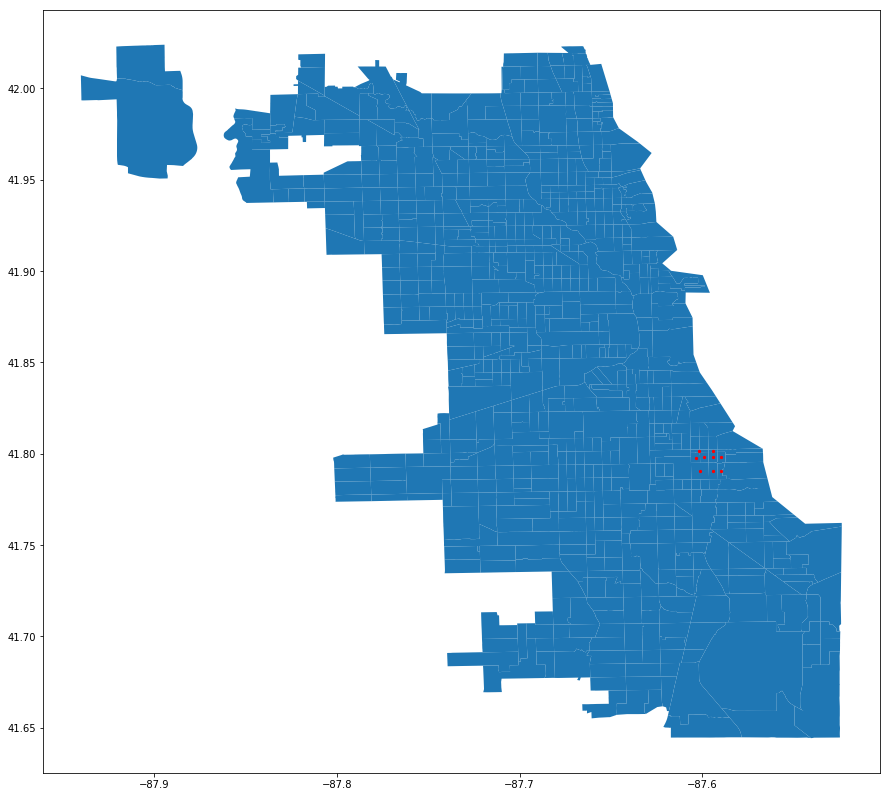

In [218]:
base = tracts.plot(figsize=(15,15))
neighborhoods_w_tracts = gpd.sjoin(tracts_center, neighborhoods, how="inner", op='within')
neighborhoods_w_tracts[neighborhoods_w_tracts.Name=='Hyde Park'].plot(
    ax=base, 
    marker='o', 
    color='red', 
    markersize=5, 
    figsize=(5,5))

In [220]:
neighborhoods_w_tracts.describe()

,commarea_n,index_right
count,787.000000,787.000000
mean,35.008895,103.020330
std,22.772493,68.212918
min,1.000000,0.000000
25%,16.500000,46.000000
50%,29.000000,88.000000
75%,56.000000,153.000000
max,77.000000,287.000000


In [221]:
import sys, os
sys.path.append('/Users/benjamin/Desktop/repos/chi-data/backend/aws') 
sys.path.append('/Users/benjamin/Desktop/repos/chi-data/backend') 
from s3 import S3
from dynamo import DynamoConn
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
%matplotlib inline
from config import cook_tracts, chicago_tracts, msa_tracts

import s3fs
s3 = s3fs.S3FileSystem()
dataset = 'JT00'
year = '2002'
ds = pq.ParquetDataset(path_or_paths=[
  'bnroths/chicago-data/lehd_od/year=%s/il_lehd_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/il_lehd_od_aux_%s_%s.parquet' % (year, dataset, year), 
    
  'bnroths/chicago-data/lehd_od/year=%s/in_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/in_od_aux_%s_%s.parquet' % (year, dataset, year), 
    
  'bnroths/chicago-data/lehd_od/year=%s/wi_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/wi_od_aux_%s_%s.parquet' % (year, dataset, year), 

], filesystem=s3, validate_schema=False)

In [222]:
table = ds.read(columns=['w_tract', 'h_tract', 'S000'])
df = table.to_pandas()

#pivot = pd.pivot_table(df, values='S000', columns=['w_tract'], index=['h_tract'], aggfunc=np.sum, fill_value=0)

In [254]:
neighborhoods_w_tracts_small = neighborhoods_w_tracts[['geoid10', 'Name']].set_index('geoid10')

In [258]:
neighborhoods_w_tracts_small.columns

Index([u'Name'], dtype='object')

In [271]:
final_df = df.set_index('w_tract').join(neighborhoods_w_tracts_small).rename(columns={'Name': 'w_hood'})
final_df = final_df.set_index('h_tract').join(neighborhoods_w_tracts_small, lsuffix='left').rename(columns={'Name': 'h_hood'})




In [273]:
final_df.dropna().head(n=100)

,S000,w_hood,h_hood
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park
17031010100,1,Rogers Park,Rogers Park


In [274]:
pivot = pd.pivot_table(
    final_df, 
    values='S000', 
    columns=['w_hood'], 
    index=['h_hood'], 
    aggfunc=np.sum, 
    fill_value=0)





In [284]:
w_tracts = pivot.sum()
h_tracts = pivot.transpose().sum()
A = pivot.transpose()/h_tracts
A = A.fillna(0).replace([np.inf, -np.inf], 0)

In [292]:
print A['Goose Island'].sort_values()
w, v = np.linalg.eig(A)

w_hood
Marycrest                       0.000000
Prairie Shores                  0.000000
Hanson Park                     0.000000
Princeton Park                  0.000000
Grand Crossing                  0.000000
Pullman                         0.000000
Ravenswood Manor                0.000000
Rogers Park                     0.000000
Gladstone Park                  0.000000
Rosemoor                        0.000000
Sauganash Woods                 0.000000
Scottsdale                      0.000000
South Chicago                   0.000000
South Commons                   0.000000
Fifth City                      0.000000
Englewood                       0.000000
Magnolia Glen                   0.000000
Edgewater                       0.000000
Hegewisch                       0.000000
Edgebrook                       0.000000
Pill Hill                       0.000000
Homan Square                    0.000000
Longwood Manor                  0.000000
Morgan Park                     0.000000
Little Ca

In [291]:
print type(w[0])
print v[0].shape
print w.shape # eigenvalue
print v.shape # eigenvector
eigs = []
idx = w.argsort()[::-1]
eigenValues = w[idx]
eigenVectors = v[:,idx]

<type 'numpy.complex128'>
(190,)
(190,)
(190, 190)
